In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pandas as pd
import json
import numpy as np

### vauth

In [1]:
from google.colab import auth
auth.authenticate_user()


# preprosessing

## extract features from files and make a dataframe

In [3]:
#help function to import data as dataframes
def import_to_df(folder, start, end): 
  
  #preprosess filenames
  filenamessorted = []
  for filename in os.listdir(folder):
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
        try: 
          entry = json.loads(f.readline())
          filenamessorted.append((filename,entry['timestamp']))
        except:
          continue
  filenamessorted.sort(key=lambda a: a[1])
  files = [t[0] for t in filenamessorted]
  filessliced = files[start:end]
 
  print(filessliced)

  data = []
  errors = 0
  for filename in filessliced:
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)

  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
  df.set_index('timestamp', inplace=True)
  df = df.sort_index()

  dforiginal = df.copy()
  return df, dforiginal


## import train

In [17]:
''' ---- real call:'''
train_df,train_dforiginal = import_to_df("/content/normal",17,40);

''' ---- testing calls:'''
#train_df,train_dforiginal = import_to_df("/content/normal",17,25);
train_df.shape

# train_files = ['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022', 'data000000000024', 'data000000000023', 'data000000000025']


['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022', 'data000000000024', 'data000000000023', 'data000000000025', 'data000000000031', 'data000000000026', 'data000000000027', 'data000000000028', 'data000000000029', 'data000000000030', 'data000000000032', 'data000000000033', 'data000000000034', 'data000000000035', 'data000000000036', 'data000000000037', 'data000000000038', 'data000000000039', 'data000000000040']
Number of errors: 0


(834294, 7)

## import test

In [18]:
''' ---- real call: '''
test_df,test_dforiginal  = import_to_df("/content/anomaly",39, 50);


# ['data-000000000046', 'data-000000000034', 'data-000000000030', 'data-000000000048', 'data-000000000043']
'''---- testing calls:
'''
#test_df, test_dforiginal = import_to_df("/content/anomaly",39,42);
test_df.shape

['data-000000000046', 'data-000000000034', 'data-000000000030', 'data-000000000048', 'data-000000000043', 'data-000000000051', 'data-000000000052', 'data-000000000045', 'data-000000000047', 'data-000000000042', 'data-000000000049']
Number of errors: 0


(403497, 7)

## Latency

### plot

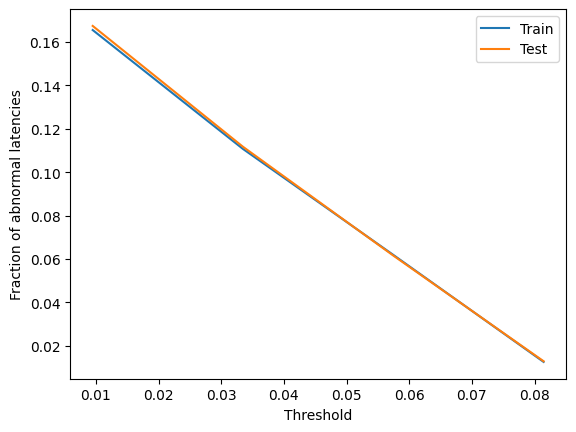

   Threshold  Train Fraction  Test Fraction
0   0.009487        0.165548       0.167446
1   0.033471        0.110739       0.111746
2   0.057456        0.061928       0.061611
3   0.081440        0.012603       0.012920


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
thresholds = []

for i in range(4):

# Define threshold for abnormal latency as three standard deviations away from the mean of TrainDF
  thresholds.append(latency_mean + i*latency_std)

# Define empty lists to store results
train_labels_list = []
train_fractions_list = []
test_labels_list = []
test_fractions_list = []

# Loop over threshold values
for threshold in thresholds:

    train_df['latency_label'] = np.where(train_df['latency'] > threshold, 1, 0)
    test_df['latency_label'] = np.where(test_df['latency'] > threshold, 1, 0)

    # Compute fraction of abnormal latencies
    train_fraction = train_df['latency_label'].value_counts()[1]/train_df.shape[0]
    test_fraction = test_df['latency_label'].value_counts()[1]/test_df.shape[0]
    #test_fraction = test_df['latency_label'].mean()

    # Append results to lists
    train_labels_list.append(train_df['latency_label'])
    train_fractions_list.append(train_fraction)
    test_labels_list.append(test_df['latency_label'])
    test_fractions_list.append(test_fraction)


# Plot results
plt.plot(thresholds, train_fractions_list, label='Train')
plt.plot(thresholds, test_fractions_list, label='Test')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Fraction of abnormal latencies')
plt.show()

# Create table of results
results = pd.DataFrame({'Threshold': thresholds, 'Train Fraction': train_fractions_list, 'Test Fraction': test_fractions_list})
print(results)


In [20]:
train_df['latency_label'].value_counts(),test_df['latency_label'].value_counts()

(0    823779
 1     10515
 Name: latency_label, dtype: int64,
 0    398284
 1      5213
 Name: latency_label, dtype: int64)

### determine

In [21]:


latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
latency_threshold = (latency_mean + 1*latency_std)
train_df['latency_label'] = np.where(train_df['latency'] > latency_threshold, 1, 0)
test_df['latency_label'] = np.where(test_df['latency'] > latency_threshold, 1, 0)


## backup and debugging

In [ ]:
print(train_dforiginal.shape, len(train_df))
print(test_dforiginal.shape, len(test_df))


(10000, 7) 10000
(10000, 7) 10000


In [ ]:
earliest_train = train_df.index.min()
latest_train = train_df.index.max()
earliest_test = test_df.index.min()
latest_test = test_df.index.max()

print("Earliest train timestamp:", earliest_train)
print("Latest train timestamp:", latest_train)
print("Earliest test timestamp:", earliest_test)
print("Latest test timestamp:", latest_test)


Earliest train timestamp: 2023-04-18 00:28:36.741168+00:00
Latest train timestamp: 2023-04-18 00:57:39.686390+00:00
Earliest test timestamp: 2023-04-21 00:07:40.949091+00:00
Latest test timestamp: 2023-04-21 01:07:49.241144+00:00


In [ ]:
# in case of error
train_df = train_dforiginal
test_df = test_dforiginal

print(train_df.head)
print(test_df.head)

## create keys and dummies

In [120]:
train_df.to_csv('trainfinal.csv', index=True)
test_df.to_csv('testfinal.csv', index=True)

In [22]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency_label', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])


# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]

In [23]:
print(train_df.shape)
print(test_df.shape)
print(test_df.head())

(834294, 615)
(403497, 615)
                                  key_0  key_1  key_2  key_3  key_4  key_5  \
timestamp                                                                    
2023-04-21 13:06:18.757041+00:00      0      0      0      0      0      0   
2023-04-21 13:06:23.974268+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.258780+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.379785+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.383645+00:00      0      0      0      0      0      0   

                                  key_6  key_7  key_8  key_9  ...  key_605  \
timestamp                                                     ...            
2023-04-21 13:06:18.757041+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:23.974268+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:24.258780+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:24.379785+00:00   

# AUTOENCODER

## gpu test

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## timeseries

In [48]:
num_steps = 30
features = train_df.shape[1]

train_batches = (train_df.shape[0] // num_steps) * num_steps
train_data = train_df.iloc[:train_batches]

features = train_df.shape[1]
x_train_shaped = np.reshape(train_data.to_numpy(), newshape=(-1, num_steps, features))


In [49]:
test_batches = (test_df.shape[0] // num_steps) * num_steps
test_data = test_df.iloc[:test_batches]

features = test_df.shape[1]
x_test_shaped = np.reshape(test_data.to_numpy(), newshape=(-1, num_steps, features))


In [26]:
x_train_shaped.shape, x_test_shaped.shape

((55619, 15, 615), (26899, 15, 615))

## define model

In [50]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense


# Define the model 
model = Sequential()

# Encoder
model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(x_train_shaped.shape[1]))

# Decoder
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 30, 128)           380928    
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_7 (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                                 
 lstm_30 (LSTM)              (None, 30, 64)            33024     
                                                                 
 lstm_31 (LSTM)              (None, 30, 128)           98816     
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 615)          79335     
 tributed)                                            

In [37]:
model.layers[0].input_shape


(None, 15, 559)

### fit

Epoch 1/150
696/696 [==============================] - 17s 15ms/step - loss: 0.0015 - accuracy: 0.1591 - val_loss: 0.0015 - val_accuracy: 0.1773
Epoch 2/150
696/696 [==============================] - 8s 12ms/step - loss: 0.0015 - accuracy: 0.1987 - val_loss: 0.0014 - val_accuracy: 0.2385
Epoch 3/150
696/696 [==============================] - 8s 12ms/step - loss: 0.0014 - accuracy: 0.2530 - val_loss: 0.0014 - val_accuracy: 0.2665
Epoch 4/150
696/696 [==============================] - 8s 11ms/step - loss: 0.0013 - accuracy: 0.2984 - val_loss: 0.0013 - val_accuracy: 0.3146
Epoch 5/150
696/696 [==============================] - 8s 11ms/step - loss: 0.0013 - accuracy: 0.3380 - val_loss: 0.0012 - val_accuracy: 0.3480
Epoch 6/150
696/696 [==============================] - 8s 12ms/step - loss: 0.0012 - accuracy: 0.3625 - val_loss: 0.0012 - val_accuracy: 0.3729
Epoch 7/150
696/696 [==============================] - 8s 11ms/step - loss: 0.0012 - accuracy: 0.3790 - val_loss: 0.0012 - val_accuracy

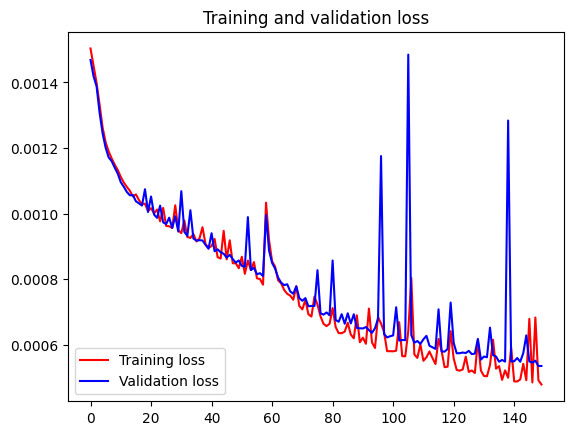

In [51]:
import matplotlib.pyplot as plt

epochs = 150
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

# Plot training and validation loss over epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

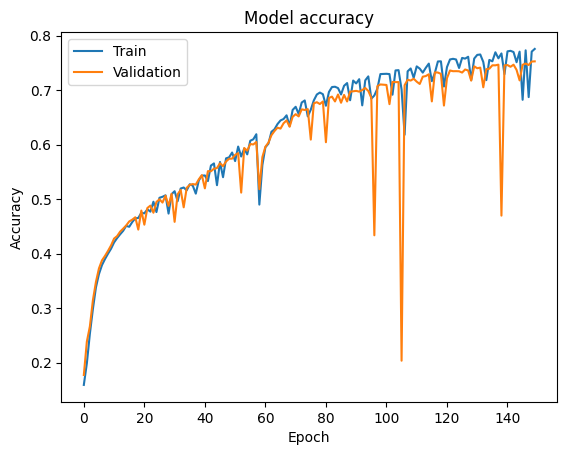

In [52]:
import matplotlib.pyplot as plt

# load the best weights
model.load_weights(checkpoint_filepath)

# Get the value of the validation accuracy at each epoch
val_acc = history.history['val_accuracy']

# Get the epoch with the highest validation accuracy
best_epoch = np.argmax(val_acc)

# plot accuracy
plt.plot(model.history.history['accuracy'][:150])
plt.plot(model.history.history['val_accuracy'][:150])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


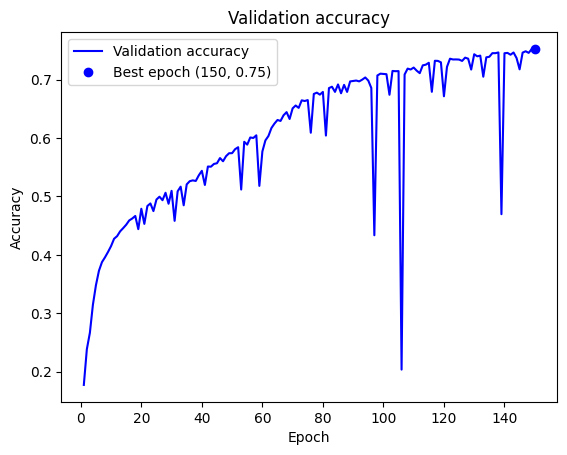

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined val_acc and best_epoch as shown in the previous code snippet

# Plot validation accuracy vs. epoch
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# Add a point at the best epoch
best_val_acc = val_acc[best_epoch]
plt.plot(best_epoch + 1, best_val_acc, 'bo', label=f'Best epoch ({best_epoch + 1}, {best_val_acc:.2f})')

# Add labels and legend
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### predict train

In [54]:
X_pred = model.predict(x_train_shaped)
X_pred_test = model.predict(x_test_shaped)
model.save('modelfull30.h5')



421/421 [==============================] - 2s 4ms/step


### scatter plot

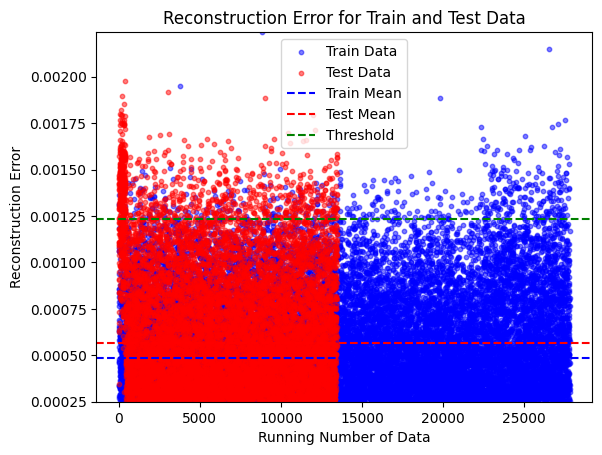

In [64]:
import matplotlib.pyplot as plt

# Set the threshold for the reconstruction error to filter out values below 0.001
visual_threshold = 0.00025



# Convert the error values to NumPy arrays
train_errors = np.array(mse_train)
test_errors = np.array(mse_test)


# Create a mask to filter the data points based on the visual_threshold
train_mask = train_errors >= visual_threshold
test_mask = test_errors >= visual_threshold

# Generate the x-axis values (running number of the data in order)
x_axis_train = np.arange(len(x_train_shaped))
x_axis_test = np.arange(len(x_test_shaped))


# Means
train_mean = np.mean(train_errors)
test_mean = np.mean(test_errors)



# Plot the reconstruction errors
plt.scatter(x_axis_train[train_mask], train_errors[train_mask], label='Train Data', color='blue', s=10, alpha=0.5)
plt.scatter(x_axis_test[test_mask], test_errors[test_mask], label='Test Data', color='red', s=10, alpha=0.5)

plt.axhline(y=train_mean, color='blue', linestyle='--', label='Train Mean')
plt.axhline(y=test_mean, color='red', linestyle='--', label='Test Mean')
plt.axhline(y=0.001235, color='green', linestyle='--', label='Threshold')


# Add labels and title to the plot
plt.xlabel('Running Number of Data')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for Train and Test Data')

# Set the y-axis limits to show values above the visual_threshold
plt.ylim([visual_threshold, max(max(train_errors), max(test_errors))])


# Add legend to the plot
plt.legend()

# Display the plot
plt.show()


### save model

# Classify

In [10]:
from sklearn.metrics import mean_squared_error

# Iterate over each sequence in X_train

def calc_mse(X,X_predict):
  mse_list = []
  for i in range(X.shape[0]):
      # Get the current sequence
      sequence = X[i]

      # Calculate the mean squared error for the sequence
      mse = mean_squared_error(sequence, X_predict[i])
      mse_list.append(mse)
  return mse_list

In [55]:
mse_train = calc_mse(x_train_shaped, X_pred)
mse_test = calc_mse(x_test_shaped, X_pred_test)


# approx the best threshold

In [65]:
import pandas as pd
import numpy as np
def threshold_loop(mse_train,mse_test):
  mean_error = np.mean(mse_train)
  std_error = np.std(mse_train)

  def classify(mse_list, threshold):
    classified = []
    for i in range(len(mse_list)):
      classified.append(0 if mse_list[i] < threshold else 1)
    return classified

  # Set threshold as a certain number of standard deviations from the mean
  std_deviations = [0.1, 0.5, 1, 1.5, 2,2.5, 3, 3.5, 4, 5, 10]
  results = []

  for num_std in std_deviations:
    threshold = mean_error + num_std * std_error
    train_classified = classify(mse_train, threshold)
    test_classified = classify(mse_test, threshold)

    TP = test_classified.count(1)
    FP = train_classified.count(1)
    TN = train_classified.count(0)
    FN = test_classified.count(0)
    try:
      accuracy = (TP + TN) / (TP + FP + TN + FN)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1_score = 2 * (precision * recall) / (precision + recall)
      specificity = TN / (TN + FP)
      fpr = FP / (TN + FP)
    except Exception as err:
      print(err)
      continue
    results.append({
        'SDs': num_std,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Specificity': specificity,
        'FPR': fpr
    })

  # Create table of results
  results_df = pd.DataFrame(results)

  return results_df


In [66]:
results_df = threshold_loop(mse_train,mse_test)
results_df

float division by zero
division by zero


,SDs,Threshold,Accuracy,Precision,Recall,F1-score,Specificity,FPR
0,0.1,0.000516,0.560376,0.363462,0.464049,0.407642,0.606962,0.393038
1,0.5,0.000636,0.603059,0.383846,0.359729,0.371397,0.720738,0.279262
2,1.0,0.000785,0.639415,0.413726,0.254591,0.315213,0.825524,0.174476
3,1.5,0.000935,0.664404,0.459988,0.169678,0.247909,0.903664,0.096336
4,2.0,0.001085,0.678293,0.532448,0.107369,0.178702,0.954403,0.045597
5,2.5,0.001235,0.681662,0.625698,0.058294,0.106652,0.983135,0.016865
6,3.0,0.001384,0.679141,0.711423,0.026396,0.050903,0.994822,0.005178
7,3.5,0.001534,0.676305,0.817568,0.008997,0.017798,0.999029,0.000971
8,4.0,0.001684,0.674512,0.777778,0.002082,0.004153,0.999712,0.000288


In [111]:
results_df.style.to_latex()

TypeError: ignored

# AUTOENCODER AS FUNCTION

In [14]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense

window_results_df = pd.DataFrame(columns=['seq_len', 'best_acc'])

def autoencode(seq_len, epochs):
  
  #print('TRAINDF SHAPE: ' + str(train_df.shape))
  '''preprosses'''
  def shape(df):
    features = train_df.shape[1]
    batches = (df.shape[0] // seq_len) * seq_len
    data = df.iloc[:batches]

    df_shaped = np.reshape(data.to_numpy(), newshape=(-1, seq_len, features))

    return df_shaped


  x_train_shaped = shape(train_df.copy())
  x_test_shaped = shape(test_df.copy())
  #print("X_TRAIN_SHAPED SHAPE: " + str(x_train_shaped.shape))
  '''define model'''
  model = Sequential()

  # Encoder
  model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(RepeatVector(x_train_shaped.shape[1]))

  # Decoder
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

  model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
  print("******* SUMMARY WITH SEQ_LEN: " + str(seq_len))
  print(model.summary())

  '''fit'''

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


  history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

  # Plot training and validation loss over epochs
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss at seq len {}'.format(seq_len))
  plt.legend()
  plt.show()

  ''''pred & results '''

  print("****** PREDICTING *******")
  X_pred = model.predict(x_train_shaped)
  X_pred_test = model.predict(x_test_shaped)
  #model.save('model{}.h5'.format(seq_len))

  #print("****** MSE CALC *******")
  mse_train = calc_mse(x_train_shaped, X_pred)
  mse_test = calc_mse(x_test_shaped, X_pred_test)

  print("****** {} THRESHOLD LOOPING *******".format(seq_len))
  current_results_df = threshold_loop(mse_train,mse_test)

  print("********* RESULTS ********")
  print(current_results_df)
  print("***********")
  
  best_row = current_results_df.iloc[current_results_df['Accuracy'].idxmax()]
  window_results_df.loc[seq_len] = [seq_len, best_row]

  # save the model
  model.save('model{}epoch100.h5'.format(seq_len))
  
  

******* SUMMARY WITH SEQ_LEN: 150
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 150, 128)          349184    
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 150, 64)          0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 150, 64)           33024     
                                                                 
 lstm_15 (LSTM)              (None, 150, 128)          98816     
                                                                 
 time_distributed_3 (TimeDis  (None, 150, 553)         71337     
 tributed)          

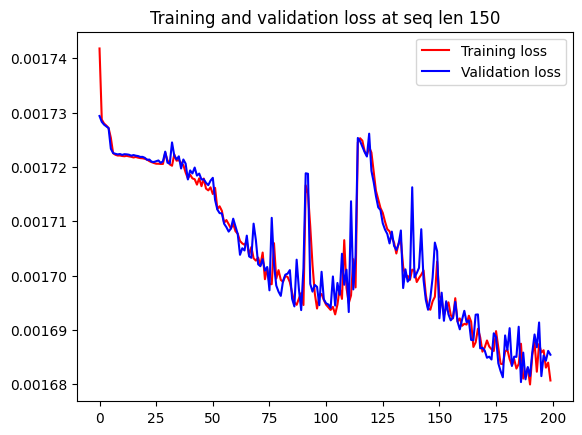

****** PREDICTING *******
21/21 [==============================] - 0s 9ms/step
****** 150 THRESHOLD LOOPING *******
division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001688  0.508365   0.234057  0.525915  0.323944     0.503300   
1  0.50   0.001708  0.570843   0.233363  0.400915  0.295008     0.619886   
2  1.00   0.001732  0.692045   0.270522  0.221037  0.243289     0.827981   
3  1.10   0.001737  0.712871   0.255937  0.147866  0.187440     0.875935   
4  1.25   0.001745  0.742574   0.266667  0.085366  0.129330     0.932248   
5  1.30   0.001747  0.754865   0.293333  0.067073  0.109181     0.953366   
6  1.40   0.001752  0.767497   0.352941  0.045732  0.080972     0.975803   
7  1.50   0.001757  0.776033   0.500000  0.028963  0.054755     0.991641   
8  1.75   0.001769  0.776033   0.500000  0.007622  0.015015     0.997800   
9  2.00   0.001782  0.775691   0.333333  0.001524  0.003035    

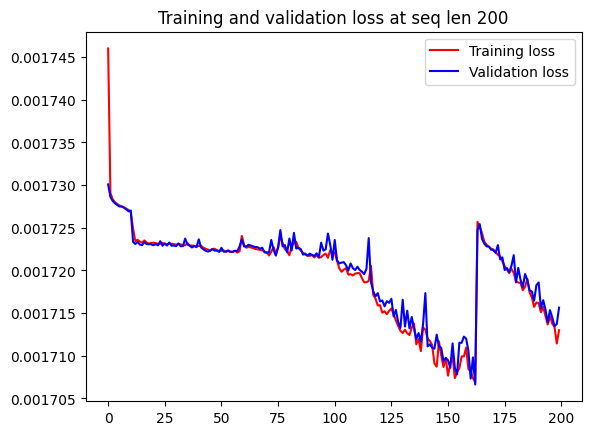

****** PREDICTING *******
16/16 [==============================] - 0s 12ms/step
****** 200 THRESHOLD LOOPING *******
division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001717  0.473828   0.221008  0.534553  0.312723     0.456305   
1  0.50   0.001728  0.586709   0.239348  0.388211  0.296124     0.643988   
2  1.00   0.001741  0.709149   0.247423  0.146341  0.183908     0.871554   
3  1.10   0.001744  0.735548   0.274112  0.109756  0.156749     0.916129   
4  1.25   0.001748  0.755576   0.307692  0.073171  0.118227     0.952493   
5  1.30   0.001749  0.762403   0.336957  0.063008  0.106164     0.964223   
6  1.40   0.001751  0.766500   0.327869  0.040650  0.072333     0.975953   
7  1.50   0.001754  0.773327   0.411765  0.028455  0.053232     0.988270   
8  1.75   0.001761  0.776513   0.555556  0.010163  0.019960     0.997654   
9  2.00   0.001767  0.776969   1.000000  0.004065  0.008097   

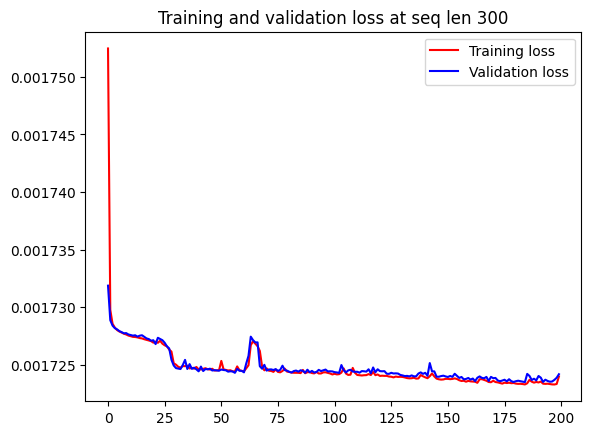

****** PREDICTING *******
11/11 [==============================] - 0s 17ms/step
****** 300 THRESHOLD LOOPING *******
float division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001725  0.475410   0.220102  0.527439  0.310592     0.460387   
1  0.50   0.001732  0.591530   0.232143  0.356707  0.281250     0.659331   
2  1.00   0.001740  0.713115   0.270000  0.164634  0.204545     0.871479   
3  1.10   0.001742  0.730874   0.273973  0.121951  0.168776     0.906690   
4  1.25   0.001744  0.753415   0.318681  0.088415  0.138425     0.945423   
5  1.30   0.001745  0.759563   0.333333  0.073171  0.120000     0.957746   
6  1.40   0.001747  0.763661   0.333333  0.054878  0.094241     0.968310   
7  1.50   0.001748  0.770492   0.388889  0.042683  0.076923     0.980634   
8  1.75   0.001752  0.774590   0.437500  0.021341  0.040698     0.992077   
9  2.00   0.001756  0.775273   0.428571  0.009146  0.017

,seq_len,best_row
150,150,SDs 1.500000 Threshold 0.00175...
200,200,SDs 2.000000 Threshold 0.00176...
300,300,SDs 2.000000 Threshold 0.00175...


In [16]:
window_results_df = pd.DataFrame(columns=['seq_len', 'best_row'])
epochs = 200
for seq_len in [150, 200, 300]:
  autoencode(seq_len, epochs)
window_results_df

In [21]:
window_results_df.to_csv('5to20.csv')

******* SUMMARY WITH SEQ_LEN: 15
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 15, 128)           352256    
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_10 (RepeatVec  (None, 15, 64)           0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 15, 64)            33024     
                                                                 
 lstm_43 (LSTM)              (None, 15, 128)           98816     
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 559)          72111     
 stributed)         

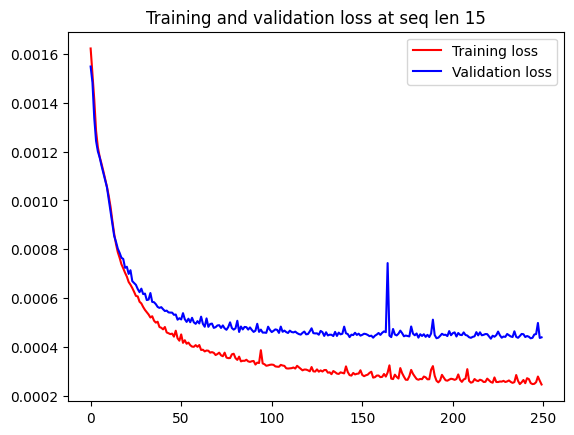

****** PREDICTING *******
408/408 [==============================] - 1s 3ms/step
****** 15 THRESHOLD LOOPING *******


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,seq_len,best_row


In [22]:
results30_df = pd.DataFrame(columns=['seq_len', 'best_row'])
epochs = 250
for seq_len in [15]:
  autoencode(seq_len, epochs)
results30_df

# Legacy

In [84]:
TP = test_classified.count(1)
FP = train_classified.count(1)
TN = train_classified.count(0)
FN = test_classified.count(0)

NameError: ignored

In [ ]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
fpr = FP / (TN + FP)


In [ ]:
confusion_matrix = pd.DataFrame(
    {
        '': ['Actual Positive', 'Actual Negative'],
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }
)

# Convert the dataframe to a LaTeX table
confusion_matrix_latex = confusion_matrix.style.to_latex()

# Print the table and the metrics
print(confusion_matrix_latex)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

\begin{tabular}{llrr}
 &  & Predicted Positive & Predicted Negative \\
0 & Actual Positive & 853 & 147 \\
1 & Actual Negative & 345 & 655 \\
\end{tabular}

Accuracy: 0.75
Precision: 0.71
Recall: 0.85
F1-score: 0.78
